## Calculating mass, radius and moment of inertia

In this notebook we will show how to calculate the exterior spacetime parameters M, R and I for a given equation of state (EoS) and the star's central density. The model that we use for the parameterization of the EoS is a piecewise polytrope, described in Raaijmakers et al. (2017). We start by importing the relevant functions from the files "Generate_Params_Par.py" and "Create_MRcurves_Par.py".

In [1]:
from Generate_Params_Par import generate_params, calc_causal_limit, calc_maxrho
from Create_MRcurves_Par import crust_EOS, calculate_MR, calculate_MR_all
from InputPosteriors import Create_Input_Posterior, Pobs, find_CI_level

from scipy.interpolate import UnivariateSpline
import numpy
from scipy.signal import argrelextrema
from matplotlib import pyplot

In [18]:
#help(generate_params)
#help(calc_maxrho)
#help(calculate_MR_all)
#help(calculate_MR)

First we create the input parameters, for each EoS we have three parameters setting the pressure at three fixed 
densities, with a piecewise polytrope in between. Here we choose the mininum and maximum polytropic index 
that is allowed to be 0.5 and 5.5 respectively and the number of points for each parameter to be 4.

In [2]:
ParametersInput = generate_params(4, 1., 5.)
len(ParametersInput)

12

Next we calculate for each set of parameters the maximum density for which the EoS is still causal, i.e. c$_s$< c

In [3]:
max_rho = calc_maxrho(ParametersInput)
max_rho

array([  3.16227766e+16,   2.48390588e+15,   2.74548211e+16,
         1.43280202e+15,   2.81565591e+16,   1.44005268e+15,
         1.83486283e+15,   9.96204154e+14,   1.91047404e+15,
         9.96204154e+14,   7.35896635e+14,   7.35896635e+14])

To solve the TOV-equations we have to first load the functions for the crust EoS and it's inverse. P_min is the minimum pressure for which this EoS is defined. Then we calculate the masses, radii and moments of inertia for each EoS. Some mass-radius curves
are not stable or monotonically increasing with central density, so these are discarded. This means that the output Parameters can contain less EoSs than the 
input parameters. Note that it takes around 4 seconds on a single core to calculate one mass-radius curve with 80 points. 

In [5]:
eos_crust, inveos_crust, P_min = crust_EOS()
MRIcurves, Parameters = calculate_MR_all(ParametersInput, eos_crust, inveos_crust, P_min=P_min, n=80, 
                                        logrhomax=numpy.log10(max_rho))

In [6]:
len(MRIcurves)

12

We see that from the 25 EoSs we put in, 17 result in stable mass-radius curves, which we plot below.

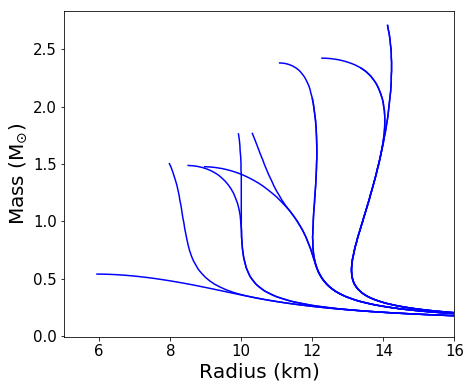

In [7]:
fig, ax = pyplot.subplots(1,1, figsize=(7,6))
for i in range(len(MRIcurves)):
    M, R, I, rhoc = MRIcurves[i]
    ax.plot(R, M, c='blue', zorder=0)
    if i==2121:
        ax.plot(R, M, c='red', zorder=1, lw=2)
ax.set_xlim(5, 16)
ax.set_xlabel('Radius (km)', fontsize=20)
ax.set_ylabel(r'Mass (M$_{\odot}$)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
pyplot.show()

## Creating a joint posterior on masses and radii

The purpose of MORSE is to transform a joint posterior distribution on neutron star masses and radii to a posterior distribution on EoS parameters. Here we will start by creating the distribution on masses and radii, which for simplicity is modelled as the product of three constituent posteriors, with each being a 2D Gaussian: 

$$ P(M, R) = \exp{\left[\frac{z (M, R)}{2\left(1 - \rho^2 \right)}\right]} $$

where

$$ z (M_i) = -\frac{(M - M_{m})^2}{\sigma_{M_{m}}^2} -  \frac{(R - R_{m})^2}{\sigma_{R_{m}}^2}  - \frac{2 \rho (M - M_{m}) (R - R_{m}) }{\sigma_{R_{m}} \sigma_{M_{m}}}  $$

To create the distribution we first pick a mass-radius curve and three masses at which the constituent posteriors will be centred. We then choose the standard deviations of the Gaussians as a percentage of their respective modes. Note that the percentages for one constituent posterior will be the same for both mass and radius.

In [16]:
## Pick a mass-radius curve ##
index = 6   
M, R, I, rhoc = MRIcurves[index] 

## Check the maximum mass of the curve, the chosen masses have to be below this value ##
print r'Maximum mass is %.2f solar mass' %max(M) 

## Interpolate the mass-radius curve ##
curve = UnivariateSpline(M, R, k=3, s=0) 

percentages = [.05, .05, .05] ## We choose a standard deviation of 5 percent of the modes ##
masses = [1.3, 1.5, 1.7]      ## We choose the masses at which the posterior is centered  ##
radii = curve(masses)         ## We calculate the corresponding radii                     ##
rhos = [0.0, 0.0, 0.0]        ## We choose a correlation of 0.0 between M and R           ##

## Create the posterior distribution on masses and radii ##
PosteriorInput = Create_Input_Posterior(percentages, masses, radii, rhos)

Maximum mass is 2.38 solar mass


We can now plot a 2D projection of the posterior distribution on masses and radii to see what it looks like. The red ellipses here indicate the 1$\sigma$ area of each constituent posterior.

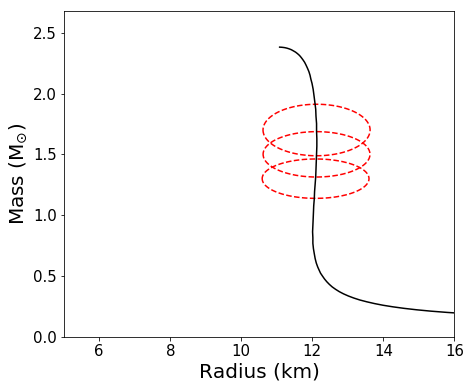

In [17]:
mi = numpy.linspace(0.2, 3.6, 400)
ri = numpy.linspace(5, 16, 400)
mig, rig = numpy.meshgrid(mi, ri)

pig = Pobs(mig, rig, PosteriorInput)
fig, ax = pyplot.subplots(1,1, figsize=(7,6))
for i in range(len(pig)):
    pi = numpy.concatenate(pig[i]).ravel()
    ax.contour(rig, mig, pig[i], linewidth=2.0,
       rstride=1, cstride=1, vmin=numpy.amin(pig[i]), vmax=numpy.amax(pig[i]),
       levels=numpy.array([find_CI_level(pi)[0]]), linestyles='--',
       colors=['red'], extend='max')
ax.plot(R, M, c='black')
ax.set_xlim(5, 16)
ax.set_ylim(0., max(M)+.3)
ax.set_xlabel('Radius (km)', fontsize=20)
ax.set_ylabel(r'Mass (M$_{\odot}$)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
pyplot.show()


## Inferring the EoS parameters